In [ ]:
!pip install textblob wordcloud numpy pandas matplotlib seaborn tqdm gensim pyLDAvis ipywidgets transformers rake-nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.5 MB/s eta 0:00:00


In [ ]:
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from tqdm.notebook import tqdm
from ipywidgets import interact, widgets
from transformers import pipeline
from rake_nltk import Rake
import re, nltk, warnings
from google.colab import files

In [ ]:
warnings.filterwarnings('ignore')
uploaded = files.upload()
for filename in uploaded.keys():
    df = pd.read_csv(filename)

print("Dataset loaded successfully!")
df.head()

Saving TestReviews.csv to TestReviews (1).csv
Dataset loaded successfully!


,review,class
0,Fantastic spot for an even or a quite cocktail...,1
1,"Love, love, love the calamari. It's so good an...",1
2,"Love this place. Stiff martinis and cocktails,...",1
3,It's everything a great cocktail bar should be...,1
4,"I came here before a pirates game, so it was a...",1


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
tqdm.pandas()
df['clean_text'] = df['review'].progress_apply(clean_text)

  0%|          | 0/4321 [00:00<?, ?it/s]

In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['clean_text'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [ ]:
aspects = ['price', 'delivery', 'quality', 'service', 'packaging', 'support', 'refund']
for aspect in aspects:
    df[f'{aspect}_mention'] = df['clean_text'].apply(lambda x: 1 if aspect in x else 0)
    df[f'{aspect}_sentiment'] = df.apply(lambda r: TextBlob(r['clean_text']).sentiment.polarity if r[f'{aspect}_mention'] == 1 else None, axis=1)

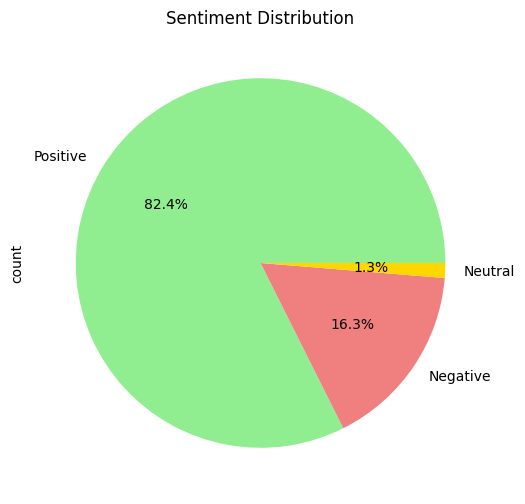

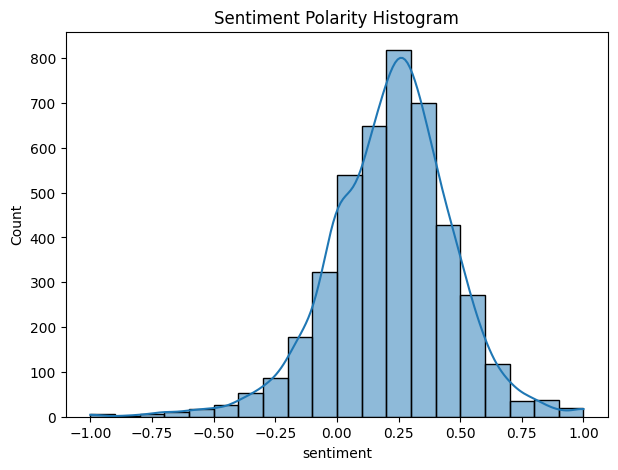

In [ ]:
plt.figure(figsize=(6,6))
df['sentiment_label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen','lightcoral','gold'])
plt.title("Sentiment Distribution")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title("Sentiment Polarity Histogram")
plt.show()

In [ ]:
def get_coherence(n_topics):
    tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['clean_text'])
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf_features = nmf.fit_transform(tfidf_matrix)
    feature_names = tfidf.get_feature_names_out()
    top_words = [[feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in nmf.components_]
    texts = [t.split() for t in df['clean_text']]
    dictionary = Dictionary(texts)
    coherence = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
    return coherence

In [ ]:
scores = {}
for n in range(2, 8):
    scores[n] = get_coherence(n)

best_n = max(scores, key=scores.get)
print(f"Optimal number of topics: {best_n}")

Optimal number of topics: 6


In [ ]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['clean_text'])
nmf_model = NMF(n_components=best_n, random_state=42)
nmf_features = nmf_model.fit_transform(tfidf_matrix)

In [ ]:
def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_words
    return topics

In [ ]:
top_words_per_topic = get_top_words(nmf_model, tfidf.get_feature_names_out())
df['dominant_topic'] = nmf_features.argmax(axis=1) + 1

In [ ]:
silhouette = silhouette_score(tfidf_matrix, df['dominant_topic'])
texts = [doc.split() for doc in df['clean_text']]
dictionary = Dictionary(texts)
topics_words = [[word for word in words] for words in top_words_per_topic.values()]
coherence_model = CoherenceModel(topics=topics_words, texts=texts, dictionary=dictionary, coherence='c_v')
topic_coherence = coherence_model.get_coherence()

In [ ]:
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Topic Coherence: {topic_coherence:.4f}")
print(f"Best Topics: {best_n}")

Silhouette Score: 0.0047
Topic Coherence: 0.5559
Best Topics: 6


In [ ]:
rake = Rake()
df['key_phrases'] = df['clean_text'].apply(lambda x: rake.extract_keywords_from_text(x) or rake.get_ranked_phrases())

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
summary_text = " ".join(df['clean_text'].tolist())[:2000]
summary = summarizer(summary_text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
print("\n**Summary of Reviews:**")
print(summary)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu



**Summary of Reviews:**
Great drink menu super attentive staff certainly recommend anything purred fruit apple really love love love calamari good spicy endless list martini one better next first second floor prefer bar lounge atmosphere place like dinner drink apps wonderful love place stiff martini cocktail cheap drink good service nice atmosphere chill upstairs lounge hang friend classy crowd much mature older professional crowd college frat boy belligerent drunk great nice place wind long day everything great cocktail bar great location ambiance cocktail chill environment disclaimer star mean new york city good


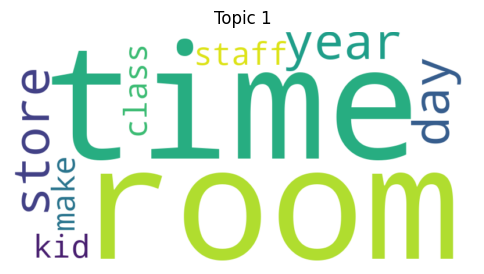

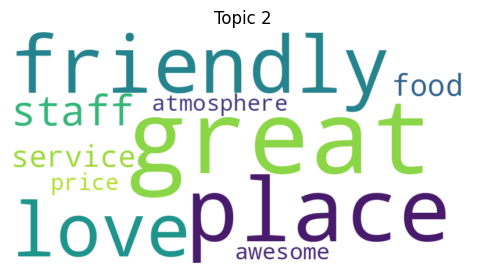

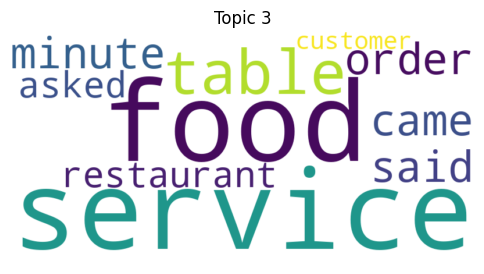

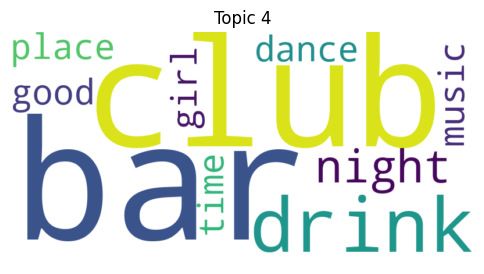

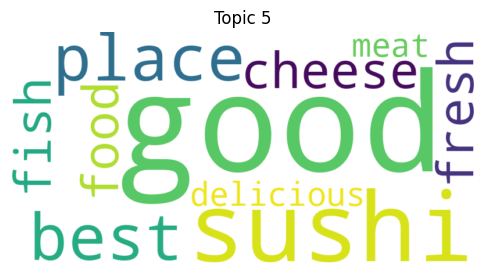

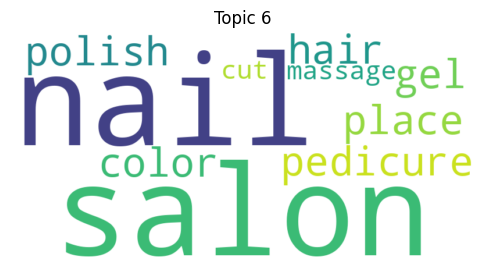

In [ ]:
for topic, words in top_words_per_topic.items():
    plt.figure(figsize=(6,4))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(topic)
    plt.show()

In [ ]:
def show_reviews(topic_num):
    display(df[df['dominant_topic'] == topic_num][['review', 'sentiment_label', 'key_phrases']].head(10))

interact(show_reviews, topic_num=widgets.IntSlider(min=1, max=best_n, step=1, value=1))

interactive(children=(IntSlider(value=1, description='topic_num', max=6, min=1), Output()), _dom_classes=('wid…

<function __main__.show_reviews(topic_num)>

In [ ]:
df.to_csv('advanced_feedback_analysis.csv', index=False)
files.download('advanced_feedback_analysis.csv')
print("\nAnalysis completed successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analysis completed successfully!
